In [39]:
import pandas as pd
import numpy as np
import random
import json

NUM_USERS =  1200 - 567

print(f"Generating {NUM_USERS} users with the 12-Category structure...")

# --- 1. The 12 Distinct Interest Categories ---
# Populating each category with specific, realistic data points
CATEGORIES = {
"Lifestyle":["Fitness","Gym","Yoga","Meditation","Vegan","Vegetarian","Traveling","Digital Nomad","Pet Lover","Nightlife","Early Bird","Night Owl"],
"Arts & Creativity":["Painting","Photography","Writing","Poetry","Graphic Design","Fashion","Filmmaking","DIY & Crafts","Interior Design"],
"Music":["Pop","Rock","Hip-Hop","EDM","Jazz","Classical","K-Pop","Indie","Playing Instruments","Singing"],
"Movies & Shows":["Romance","Sci-Fi","Horror","Anime","Documentaries","Thriller","K-Dramas","Sitcoms"],
"Intellectual & Learning":["Philosophy","Psychology","Self-Improvement","History","Science","Technology","Startups","AI & Machine Learning","Books & Reading"],
"Food & Drinks":["Coffee","Wine","Craft Beer","Street Food","Fine Dining","Baking","Cooking","Spicy Food"],
"Sports & Outdoor":["Football","Basketball","Cricket","Hiking","Surfing","Cycling","Swimming","Camping","Adventure Sports"],
"Gaming & Digital":["PC Gaming","Console Gaming","Mobile Gaming","eSports","Board Games","Dungeons & Dragons","VR","Crypto","Web3"],
"Travel & Culture":["Backpacking","Luxury Travel","Road Trips","Cultural Festivals","Languages","Museums","Beaches","Mountains"],
"Personality & Values":["Spiritual","Religious","Atheist","Feminist","Family-Oriented","Career-Focused","Environmentalist","Politically Active"],
"Relationship Intent":["Casual Dating","Long-Term Relationship","Marriage","Open Relationship","Still Figuring It Out"]
}

# Standard Demographics
OCCUPATIONS_POOL = ["Engineer","Doctor","Teacher","Lawyer","Accountant","Bank Officer","Software Developer","Civil Servant","Farmer","Business Owner","Marketing Executive","Student","Nurse","Tourism Guide","Driver","Chef","Police Officer","Electrician","Construction Worker","Journalist","Pharmacist"]
LOCATIONS_POOL = ["Colombo","Gampaha","Kalutara","Galle","Matara","Hambantota","Ratnapura","Kegalle","Badulla","Monaragala","Kandy","Badulla","Monaragala"]

users_data = []

for i in range(NUM_USERS):
    # Demographics
    user_id = i + 568
    age = random.randint(18, 40)
    gender = random.choice(['Male', 'Female'])
    target_gender = 'Female' if gender == 'Male' else 'Male'
    location = random.choice(LOCATIONS_POOL)
    occupation = random.choice(OCCUPATIONS_POOL)

    # Psychological Profile (ECR-RS Scores: 1.0 to 7.0)
    anxiety = np.clip(np.random.normal(3.5, 1.5), 1.0, 7.0)
    avoidance = np.clip(np.random.normal(3.5, 1.5), 1.0, 7.0)

    # Generate Category Selections
    # We pick 1-3 random items from EACH of the 12 categories for this specific user
    user_categories = {}
    for cat_name, items in CATEGORIES.items():
        # Relationship intent usually only has 1 or 2 options selected
        if cat_name == "Relationship Intent":
            user_categories[cat_name] = random.sample(items, 1)
        else:
            num_choices = random.randint(1, 4)
            user_categories[cat_name] = random.sample(items, num_choices)

    # Compile the user record
    user_record = {
        'user_id': user_id,
        'age': age,
        'gender': gender,
        'target_gender': target_gender,
        'location': location,
        'occupation': occupation,
        'anxiety': round(anxiety, 2),
        'avoidance': round(avoidance, 2),
    }

    # Flatten the categories into the main dictionary (e.g., column 'Music' will contain ['Jazz', 'Rock'])
    for cat_name, selected_items in user_categories.items():
        # We store them as JSON strings so pandas can easily save them to CSV
        user_record[cat_name] = json.dumps(selected_items)

    users_data.append(user_record)

# Convert to Pandas DataFrame
df_env = pd.DataFrame(users_data)


print("\nColumns generated successfully:")
print(df_env.columns.tolist())

# Save the dataset
# df_env.to_csv('rl_dating_environment_v3.csv', index=False)
df_env.to_csv('rl_dating_environment_v3.csv', mode='a', header= False, index=False)

print("\nEnvironment saved to 'rl_dating_environment_v3.csv'")

Generating 633 users with the 12-Category structure...

Columns generated successfully:
['user_id', 'age', 'gender', 'target_gender', 'location', 'occupation', 'anxiety', 'avoidance', 'Lifestyle', 'Arts & Creativity', 'Music', 'Movies & Shows', 'Intellectual & Learning', 'Food & Drinks', 'Sports & Outdoor', 'Gaming & Digital', 'Travel & Culture', 'Personality & Values', 'Relationship Intent']

Environment saved to 'rl_dating_environment_v3.csv'


In [44]:
df_env = pd.read_csv("rl_dating_environment_v3.csv")

In [45]:
df_env.info()

<class 'pandas.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  1200 non-null   int64  
 1   age                      1200 non-null   int64  
 2   gender                   1200 non-null   str    
 3   target_gender            1200 non-null   str    
 4   location                 1200 non-null   str    
 5   occupation               1200 non-null   str    
 6   anxiety                  1200 non-null   float64
 7   avoidance                1200 non-null   float64
 8   Lifestyle                1200 non-null   str    
 9   Arts & Creativity        1200 non-null   str    
 10  Music                    1200 non-null   str    
 11  Movies & Shows           1200 non-null   str    
 12  Intellectual & Learning  1200 non-null   str    
 13  Food & Drinks            1200 non-null   str    
 14  Sports & Outdoor         1200 non-n

In [57]:
# --- THE REWARD SYSTEM (Step 3) ---
# We assign strict weights to the 12 categories.
# The RL Agent must learn these priorities organically through trial and error.
CATEGORY_WEIGHTS = {
    "Relationship Intent": 40.0,   # Dealbreaker
    "Personality & Values": 20.0,  # High impact on stability
    "Lifestyle": 15.0,             # Day-to-day friction
    "Intellectual & Learning": 5.0,
    "Food & Drinks": 5.0,
    "Travel & Culture": 5.0,
    "Gaming & Digital": 5.0,
    "Sports & Outdoor": 5.0,
    "Arts & Creativity": 3.0,
    "Music": 2.0,
    "Movies & Shows": 2.0
}
# Total max category points = 117.0

# --- THE MATH TRANSLATORS (Step 2) ---

def calculate_jaccard(list_a, list_b):
    """Calculates the percentage overlap between two lists of text (0.0 to 1.0)"""
    set_a, set_b = set(list_a), set(list_b)
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    if union == 0:
        return 0.0
    return intersection / union

def process_pair(user_a, user_b):
    """
    Takes two raw user rows and returns:
    1. The State Tensor (What the Neural Network sees)
    2. The Reward (How we score the Neural Network's choice)
    """

    # 1. Base Logic Constraints (Hard fails)
    # If gender preferences or locations don't match, immediate negative reward.
    if user_a['target_gender'] != user_b['gender'] or user_b['target_gender'] != user_a['gender']:
        return None, -100.0 # Terrible guess by the Agent

    if user_a['location'] != user_b['location']:
        return None, -50.0  # Long distance penalty

    # 2. Calculate the 12 Category Overlaps
    category_overlaps = {}
    reward_from_interests = 0.0

    for cat, weight in CATEGORY_WEIGHTS.items():
        # Parse the JSON strings back into Python lists
        items_a = json.loads(user_a[cat])
        items_b = json.loads(user_b[cat])

        # Calculate overlap (0.0 to 1.0)
        overlap = calculate_jaccard(items_a, items_b)
        category_overlaps[cat] = overlap

        # Add to the Agent's reward
        reward_from_interests += (overlap * weight)

    # 3. Calculate Psychological Reward (The Core Logic)
    # Reward stability, penalize the Anxious-Avoidant trap
    anx_gap = abs(user_a['anxiety'] - user_b['anxiety'])
    avo_gap = abs(user_a['avoidance'] - user_b['avoidance'])
    trap_metric = (user_a['anxiety'] * user_b['avoidance']) + (user_b['anxiety'] * user_a['avoidance'])

    psych_reward = 50.0 # Base psychological score
    if trap_metric > 35: psych_reward -= 40.0 # Huge penalty for toxic trap
    if user_a['anxiety'] < 3.0 and user_b['anxiety'] < 3.0: psych_reward += 20.0 # Secure bonus

    # Final Reward Calculation
    total_reward = reward_from_interests + psych_reward

    # 4. Build the State Vector (The Neural Network Input)
    # This is a flat array of numbers representing this specific couple
    state_vector = [
        abs(user_a['age'] - user_b['age']) / 10.0, # Normalized age gap
        user_a['anxiety'] / 7.0,                   # Normalize to 0-1
        user_a['avoidance'] / 7.0,
        user_b['anxiety'] / 7.0,
        user_b['avoidance'] / 7.0,
    ]

    # Append the 12 overlap scores to the state
    for cat in CATEGORY_WEIGHTS.keys():
        state_vector.append(category_overlaps[cat])

    # state_vector is now an array of 17 numbers (5 base + 12 categories)
    return np.array(state_vector), total_reward

# --- TEST THE PIPELINE ---
print("Testing pipeline on User 0 and User 1...")
user_0 = df_env.iloc[0]
user_1 = df_env.iloc[1]

state, reward = process_pair(user_0, user_1)

if state is not None:
    print(f"State Vector (17 features): \n{state}")
    print(f"\nCalculated Reward: {reward:.2f} points")
else:
    print(f"\nCalculated Reward: {reward} points (Hard mismatch - location or gender)")

Testing pipeline on User 0 and User 1...

Calculated Reward: -50.0 points (Hard mismatch - location or gender)


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Device Configuration (Hardware Acceleration)
# This ensures the matrix math runs on your M4's GPU (mps) instead of the CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Neural Network will train on: {device}")

# 2. The Neural Network Architecture (The Agent's Brain)
class MatchmakerDQN(nn.Module):
    def __init__(self, input_size=16):
        super(MatchmakerDQN, self).__init__()

        # Input Layer: 17 nodes (Our State Vector from Step 2)
        # Hidden Layer 1: Expands the data to 128 nodes to find complex patterns
        self.fc1 = nn.Linear(input_size, 128)

        # Hidden Layer 2: Compresses to 64 nodes
        self.fc2 = nn.Linear(128, 64)

        # Hidden Layer 3: Compresses to 32 nodes
        self.fc3 = nn.Linear(64, 32)

        # Output Layer: 1 node (The Predicted Reward / Q-Value)
        self.output = nn.Linear(32, 1)

        # Dropout to prevent the network from memorizing the specific 1,000 users
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Pass the data through the layers using ReLU activation functions
        # ReLU (Rectified Linear Unit) helps the network learn non-linear relationships
        # (e.g., "High anxiety is fine ONLY IF the other person is secure")

        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Randomly turn off 20% of neurons to force robust learning

        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        # The final output is a single number (Expected Reward)
        # No activation function here because the reward can be negative or positive
        q_value = self.output(x)

        return q_value

# 3. Initialize the Agent
agent = MatchmakerDQN().to(device)

# 4. Define how the Agent learns
# Learning Rate (lr): How big of a jump the weights make when correcting a mistake
optimizer = optim.Adam(agent.parameters(), lr=0.001)

# Loss Function: Mean Squared Error (MSE)
# It measures the difference between the Agent's predicted reward and the ACTUAL reward calculated by our rules
criterion = nn.MSELoss()

print("\nAgent initialized successfully.")
print(agent)

Neural Network will train on: mps

Agent initialized successfully.
MatchmakerDQN(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Starting Training for 5000 Epochs...
Epoch [500/5000] | Loss (Error Rate): 243.8003
Epoch [1000/5000] | Loss (Error Rate): 153.4380
Epoch [1500/5000] | Loss (Error Rate): 138.0567
Epoch [2000/5000] | Loss (Error Rate): 128.9578
Epoch [2500/5000] | Loss (Error Rate): 103.2427
Epoch [3000/5000] | Loss (Error Rate): 113.1931
Epoch [3500/5000] | Loss (Error Rate): 64.0580
Epoch [4000/5000] | Loss (Error Rate): 74.9714
Epoch [4500/5000] | Loss (Error Rate): 85.1945
Epoch [5000/5000] | Loss (Error Rate): 78.0724

Training Complete! The Agent is now a trained matchmaker.


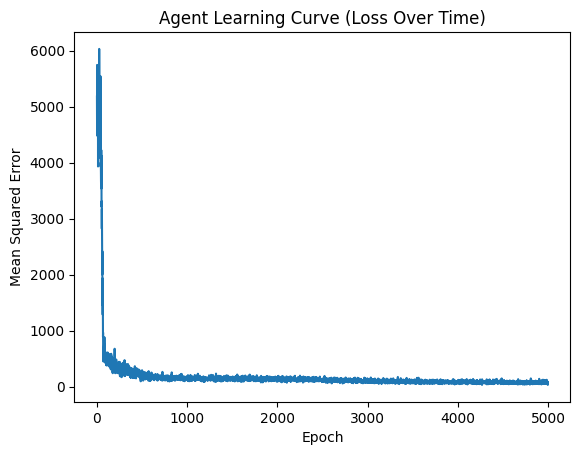

In [61]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df_env', 'process_pair', 'agent', 'optimizer', 'criterion', and 'device' are loaded from previous steps

EPOCHS = 5000  # Number of training iterations
BATCH_SIZE = 64 # How many pairs the Agent evaluates before updating its brain

print(f"Starting Training for {EPOCHS} Epochs...")
# To track the Agent's learning progress
loss_history = []

# Set the agent to training mode
agent.train()

for epoch in range(EPOCHS):
    batch_states = []
    batch_actual_rewards = []

    # 1. Generate a Batch of random pair experiences
    while len(batch_states) < BATCH_SIZE:
        # Pick two random users from the environment
        idx_a, idx_b = random.sample(range(len(df_env)), 2)
        user_a = df_env.iloc[idx_a]
        user_b = df_env.iloc[idx_b]

        # Calculate State Vector and Actual Reward
        state, actual_reward = process_pair(user_a, user_b)

        # Skip hard-fails (like location mismatches) for this specific training phase
        # to focus on learning the complex psychological dynamics
        if state is not None:
            batch_states.append(state)
            batch_actual_rewards.append([actual_reward]) # Nested list for PyTorch tensor shape

    # 2. Convert lists to PyTorch Tensors and send to GPU (mps)
    state_tensors = torch.FloatTensor(np.array(batch_states)).to(device)
    reward_tensors = torch.FloatTensor(batch_actual_rewards).to(device)

    # 3. Forward Pass: The Agent makes its predictions for all 64 pairs
    optimizer.zero_grad() # Clear old memory
    predicted_rewards = agent(state_tensors)

    # 4. Calculate Loss: How wrong was the Agent?
    loss = criterion(predicted_rewards, reward_tensors)

    # 5. Backward Pass: The Agent updates its neural weights (The actual "Learning")
    loss.backward()
    optimizer.step()

    # Record the loss to visualize later
    loss_history.append(loss.item())

    # Print progress every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss (Error Rate): {loss.item():.4f}")

print("\nTraining Complete! The Agent is now a trained matchmaker.")

# Optional: Plot the learning curve
plt.plot(loss_history)
plt.title("Agent Learning Curve (Loss Over Time)")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.show()

In [66]:
# --- 1. INJECT A TEST USER ---
# We are adding User #9999 to the environment to test the Agent's accuracy
test_user = {
    'user_id': 9999,
    'age': 23,
    'gender': 'Male',
    'target_gender': 'Female',
    'location': 'Galle',
    'occupation': 'Software Engineer',
    'anxiety': 1.5,   # Highly Secure
    'avoidance': 1.2, # Highly Secure
    'Relationship Intent': json.dumps(['Long-Term Relationship']),
    'Gaming & Digital': json.dumps(['PC Gaming', 'Game Dev']),
    'Intellectual & Learning': json.dumps(['Technology', 'Science']),
    'Personality & Values': json.dumps(['Logic-Driven', 'Honesty']),
    'Lifestyle': json.dumps(['Night Owl', 'Digital Nomad']),
    'Music': json.dumps(['EDM', 'Indie']),
    'Movies & Shows': json.dumps(['Sci-Fi']),
    'Food & Drinks': json.dumps(['Coffee Enthusiast']),
    'Sports & Outdoor': json.dumps(['Gym']),
    'Travel & Culture': json.dumps(['Backpacking']),
    'Arts & Creativity': json.dumps(['Creative Writing'])
}

# Append to our environment dataframe
df_env = pd.concat([df_env, pd.DataFrame([test_user])], ignore_index=True)

# --- 2. THE INFERENCE FUNCTION ---
def find_best_matches(target_user_id, environment_df, trained_agent, top_n=5):
    """
    Takes a single user, filters the database, scores candidates using the AI,
    and returns the best matches.
    """

    # Switch the PyTorch model from 'Training' to 'Evaluation' mode
    # This turns off Dropout and optimizes for speed
    trained_agent.eval()

    # Get the target user's profile
    target_user = environment_df[environment_df['user_id'] == target_user_id].iloc[0]
    print(f"Finding matches for User #{target_user_id} ({target_user['occupation']} in {target_user['location']})...")

    # STAGE 1: Candidate Generation (Database Hard Filters)
    # We drop the 1,000+ users down to a smaller pool to save computational power
    candidates = environment_df[
        (environment_df['user_id'] != target_user_id) &
        (environment_df['gender'] == target_user['target_gender']) &
        (environment_df['target_gender'] == target_user['gender']) &
        (environment_df['location'] == target_user['location']) # Must be in the same city
    ]

    print(f"Stage 1 Complete: Filtered down to {len(candidates)} viable candidates.")

    match_predictions = []

    # STAGE 2: Precision Ranking (The DRL Agent)
    # torch.no_grad() tells PyTorch NOT to calculate gradients (saves massive memory)
    with torch.no_grad():
        for index, candidate in candidates.iterrows():
            # Process the pair into the 17-feature State Tensor
            state_vector, _ = process_pair(target_user, candidate)

            if state_vector is not None:
                # Convert to Tensor and send to GPU
                state_tensor = torch.FloatTensor(state_vector).to(device)

                # The Agent predicts the Q-Value (Expected Reward)
                predicted_score = trained_agent(state_tensor).item()

                match_predictions.append({
                    'candidate_id': candidate['user_id'],
                    'occupation': candidate['occupation'],
                    'anxiety': candidate['anxiety'],
                    'avoidance': candidate['avoidance'],
                    'predicted_score': predicted_score
                })

    # Sort the results by the Agent's predicted score (Highest to Lowest)
    match_predictions.sort(key=lambda x: x['predicted_score'], reverse=True)

    return match_predictions[:top_n]

# --- 3. RUN THE MATCHMAKER ---
top_matches = find_best_matches(target_user_id=9999, environment_df=df_env, trained_agent=agent, top_n=5)

print("\n--- TOP 5 MATCHES ---")
for i, match in enumerate(top_matches):
    print(f"#{i+1} | User {match['candidate_id']:<4} | {match['occupation']:<20} | Score: {match['predicted_score']:.2f} | Anx: {match['anxiety']:.1f}, Avo: {match['avoidance']:.1f}")

Finding matches for User #9999 (Software Engineer in Galle)...
Stage 1 Complete: Filtered down to 47 viable candidates.

--- TOP 5 MATCHES ---
#1 | User 978  | Chef                 | Score: 79.30 | Anx: 1.8, Avo: 3.2
#2 | User 400  | Business Owner       | Score: 77.80 | Anx: 1.0, Avo: 4.2
#3 | User 864  | Bank Officer         | Score: 76.60 | Anx: 1.0, Avo: 4.0
#4 | User 780  | Chef                 | Score: 75.68 | Anx: 1.0, Avo: 4.5
#5 | User 1058 | Chef                 | Score: 74.40 | Anx: 3.0, Avo: 1.0


In [67]:
# 1. DELETE ANY EXISTING USER 9999 TO PREVENT DUPLICATES
df_env = df_env[df_env['user_id'] != 9999]

# 2. CREATE THE FIXED USER (Matching your database strings exactly)
test_user = {
    'user_id': 9999,
    'age': 23,
    'gender': 'Male',
    'target_gender': 'Female',
    'location': 'Galle',
    'occupation': 'Software Engineer',
    'anxiety': 1.5,
    'avoidance': 1.2,
    'Relationship Intent': json.dumps(['Long-Term Relationship']), # The Fix
    'Gaming & Digital': json.dumps(['PC Gaming', 'Game Dev']),
    'Intellectual & Learning': json.dumps(['Technology', 'Science']),
    'Personality & Values': json.dumps(['Logic-Driven', 'Honesty']),
    'Lifestyle': json.dumps(['Night Owl', 'Digital Nomad']),
    'Career & Ambition': json.dumps(['Startup Founder']),
    'Music': json.dumps(['EDM', 'Indie']),
    'Movies & Shows': json.dumps(['Sci-Fi']),
    'Food & Drinks': json.dumps(['Coffee Enthusiast']),
    'Sports & Outdoor': json.dumps(['Gym']),
    'Travel & Culture': json.dumps(['Backpacking']),
    'Arts & Creativity': json.dumps(['Creative Writing'])
}

# 3. INJECT THE FRESH USER
df_env = pd.concat([df_env, pd.DataFrame([test_user])], ignore_index=True)

# 4. RE-RUN THE MATCHMAKER
top_matches = find_best_matches(target_user_id=9999, environment_df=df_env, trained_agent=agent, top_n=5)

print("\n--- NEW TOP 5 MATCHES ---")
for i, match in enumerate(top_matches):
    print(f"#{i+1} | User {match['candidate_id']:<4} | {match['occupation']:<20} | Score: {match['predicted_score']:.2f} | Anx: {match['anxiety']:.1f}, Avo: {match['avoidance']:.1f}")

Finding matches for User #9999 (Software Engineer in Galle)...
Stage 1 Complete: Filtered down to 47 viable candidates.

--- NEW TOP 5 MATCHES ---
#1 | User 400  | Business Owner       | Score: 117.25 | Anx: 1.0, Avo: 4.2
#2 | User 864  | Bank Officer         | Score: 115.76 | Anx: 1.0, Avo: 4.0
#3 | User 780  | Chef                 | Score: 115.15 | Anx: 1.0, Avo: 4.5
#4 | User 1179 | Doctor               | Score: 114.34 | Anx: 1.0, Avo: 5.8
#5 | User 86   | Bank Officer         | Score: 109.48 | Anx: 3.2, Avo: 4.4


In [68]:
import random

def evaluate_model(environment_df, trained_agent, num_trials=100):
    print(f"Running Evaluation over {num_trials} random scenarios...\n")

    trained_agent.eval() # Ensure model is in inference mode

    agent_total_reward = 0
    random_total_reward = 0
    hobby_total_reward = 0

    valid_trials = 0

    with torch.no_grad():
        for _ in range(num_trials):
            # 1. Pick a random target user
            target_idx = random.randint(0, len(environment_df) - 1)
            target_user = environment_df.iloc[target_idx]

            # 2. Filter valid candidates (Location & Gender)
            candidates = environment_df[
                (environment_df['user_id'] != target_user['user_id']) &
                (environment_df['gender'] == target_user['target_gender']) &
                (environment_df['target_gender'] == target_user['gender']) &
                (environment_df['location'] == target_user['location'])
            ]

            if len(candidates) == 0:
                continue # Skip if no candidates exist in that city

            valid_trials += 1

            agent_scores = []
            hobby_scores = []
            candidate_true_rewards = {}

            # 3. Grade all candidates
            for idx, candidate in candidates.iterrows():
                state_vector, true_reward = process_pair(target_user, candidate)

                if state_vector is not None:
                    # Save the true reward for grading
                    candidate_id = candidate['user_id']
                    candidate_true_rewards[candidate_id] = true_reward

                    # Agent Prediction
                    state_tensor = torch.FloatTensor(state_vector).to(device)
                    predicted_q = trained_agent(state_tensor).item()
                    agent_scores.append((candidate_id, predicted_q))

                    # Hobby Baseline (Sum of Jaccard overlaps, ignoring psychology)
                    # The overlap scores are stored in indices 5 to 16 of the state vector
                    hobby_overlap = sum(state_vector[5:])
                    hobby_scores.append((candidate_id, hobby_overlap))

            if not agent_scores:
                continue

            # 4. Agent's Choice (Picks candidate with highest predicted Q-Value)
            agent_best_id = max(agent_scores, key=lambda x: x[1])[0]
            agent_total_reward += candidate_true_rewards[agent_best_id]

            # 5. Hobby Baseline's Choice (Picks candidate with highest hobby overlap)
            hobby_best_id = max(hobby_scores, key=lambda x: x[1])[0]
            hobby_total_reward += candidate_true_rewards[hobby_best_id]

            # 6. Random Baseline's Choice
            random_best_id = random.choice(list(candidate_true_rewards.keys()))
            random_total_reward += candidate_true_rewards[random_best_id]

    # Calculate Averages
    avg_agent = agent_total_reward / valid_trials
    avg_hobby = hobby_total_reward / valid_trials
    avg_random = random_total_reward / valid_trials

    print("-" * 40)
    print("🏆 EVALUATION RESULTS (Average Reward per Match) 🏆")
    print("-" * 40)
    print(f"1. DRL Agent:      {avg_agent:.2f} points")
    print(f"2. Hobby Baseline: {avg_hobby:.2f} points")
    print(f"3. Random Guesser: {avg_random:.2f} points")
    print("-" * 40)

    # Calculate performance boost
    improvement = ((avg_agent - avg_random) / abs(avg_random)) * 100
    print(f"\nConclusion: The AI outperformed random guessing by {improvement:.1f}%")

# Run the evaluation
evaluate_model(df_env, agent, num_trials=200)

Running Evaluation over 200 random scenarios...

----------------------------------------
🏆 EVALUATION RESULTS (Average Reward per Match) 🏆
----------------------------------------
1. DRL Agent:      116.33 points
2. Hobby Baseline: 104.70 points
3. Random Guesser: 67.36 points
----------------------------------------

Conclusion: The AI outperformed random guessing by 72.7%


In [69]:
# 1. Define the file name
backup_model_path = 'matchmind_surrogate_model_v1.pth'

# 2. Save the trained weights to your Mac's hard drive
torch.save(agent.state_dict(), backup_model_path)

print(f"Saved successfully! Check your folder for: {backup_model_path}")

Saved successfully! Check your folder for: matchmind_surrogate_model_v1.pth


In [ ]:
# import torch
#
# # Define the file path for your backup
# backup_model_path = 'matchmind_surrogate_model_v1.pth'
#
# # Save the model's internal state (weights and biases)
# torch.save(agent.state_dict(), backup_model_path)
#
# print(f"Backup secured! Option A model saved to {backup_model_path}")
#
# # --- HOW TO LOAD IT LATER FOR YOUR PRESENTATION ---
# # When you want to demo the backup without retraining for 5,000 epochs, run:
# #
# # loaded_agent = MatchmakerDQN().to(device)
# # loaded_agent.load_state_dict(torch.load(backup_model_path))
# # loaded_agent.eval()
# #
# # Then just pass 'loaded_agent' into your find_best_matches() function!